# Drizzling WFPC2 Images to use a Single Zeropoint

<div class="alert-danger">Note: The notebook in this repository 'Initialization.ipynb' goes over many of the basic concepts such as the setup of the environment/package installation and should be read first if you are new to HST images, DrizzlePac, or Astroquery.</div>

 ## Table of Contents
 [Introduction](#intro) <br>
 
 [1. Download the Data](#Data) <br>
 
 [2. Update the WCS](#WCS) <br>
 - [Backup an Image](#backup) <br>
 
 [3. Align the Image](#align) <br>
 [4. Equalize the chip sensitivities](#equalize) <br>
 [5. Drizzle-combine the images](#drizzle) <br>
 [6. Illustration of the Effects of Sensitivity Variation on Drizzling](#example) <br>
 - [Simulate an Image of Constant "Blank Sky" Background](#constant) <br>
 - [Drizzle the Original Simulated Image and the Equalized Image](#drizzling) <br>
 - [Display The Results of the Simulation Side-by-Side](#display) <br>


## Introduction <a id="intro"></a>

Extra care must be taken when using `AstroDrizzle` to combine observations from detectors comprised of multiple chips of varying sensitivity. `AstroDrizzle` works with calibrated images in units of counts (electrons or Data Numbers) or count rates and not in units of flux. It assumes that all input frames can be converted to physical flux units using a single inverse-sensitivity factor, recorded in the FITS image headers as `PHOTFLAM`, and the output drizzled product simply copies the `PHOTFLAM` keyword value from the first input image. When this occurs, the inverse-sensitivity will vary across the final drizzled product, and users will need to keep track of which sources fell on which chip when doing photometry. Moreover, varying detector sensitivities will affect the cosmic-ray rejection algorithm used by `AstroDrizzle`, and this may result in the misidentification of some good pixels as cosmic rays.

This is a typical situation when drizzle-combining images from HST instruments with different chip sensitivities, e.g. Wide Field and Planetary Camera 2 (WFPC2). For more detail, see the section on [Gain Variation](http://www.stsci.edu/instruments/wfpc2/Wfpc2_dhb/wfpc2_ch53.html) under 'Position-Dependent Photometric Corrections' in the WFPC2 Data Handbook. As a result, each of the four chips requires a [unique PHOTFLAM](http://www.stsci.edu/instruments/wfpc2/Wfpc2_dhb/wfpc2_ch52.html#1933986) header keyword value. A similar situation may occur when drizzle-combining observations taken over a span of several years as detector's sensitivity declines over time, see e.g. [ACS ISR 2016-03](https://doi.org/10.3847/0004-6256/152/3/60).

One approach is to rescale the input data so that `AstroDrizzle` can properly assume the images/chips have the same sensitivity; that is, a single `PHOTFLAM` value can be used to convert re-scaled image counts (or count-rates) to physical _integrated_ flux units. The `photeq` task in `Drizzlepac` automates this image intensity rescaling to a single inverse-sensitivity factor `PHOTFLAM`.

In this example notebook, archival WFPC2 images are used to demonstrate advanced reprocessing using `TweakReg` and `AstroDrizzle` for alignment and image combination. The notebook is based on a prior WFPC2 [example](https://www.stsci.edu/files/live/sites/www/files/home/scientific-community/software/drizzlepac/examples/_documents/DrizzlePac_EX7.pdf) but includes additional information about equalizing the chip sensitivities prior to combining. 

**NOTE:** It is important to note that `photeq` only adjusts image counts so that _integrated_ physical fluxes can be obtained using a single `PHOTFLAM`. It does nothing to account for different throughtputs at different wavelengths.

In [1]:
import shutil
import glob
import os

import matplotlib.pyplot as plt
from astropy.io import fits

from astroquery.mast import Observations
from stwcs.updatewcs import updatewcs
from drizzlepac import tweakreg, astrodrizzle, photeq

# ONLY needed for the simulation section:
import numpy as np
from stwcs.wcsutil import HSTWCS
from drizzlepac.wfpc2Data import WFPC2_GAINS

%matplotlib inline

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    


The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


## 1. Download the Data <a id="Data"></a>

This example uses WFPC2 observations of Messier 2 in the F814W filter. The data come from GO proposal [11100](http://www.stsci.edu/cgi-bin/get-proposal-info?id=11100&observatory=HST) _"Two new 'bullets' for MOND: revealing the properties of dark matter in massive merging clusters"_. Four images were acquired using a 4-pt dither box pattern, followed by two images offset with a dither-line pattern. 

The data are downloaded using the `astroquery` API to access the [MAST](http://archive.stsci.edu) archive. The `astroquery.mast` [documentation](http://astroquery.readthedocs.io/en/latest/mast/mast.html) has more examples for how to find and download data from MAST.

In [2]:
# Retrieve the observation information.
if os.path.isdir('mastDownload'):
    shutil.rmtree('mastDownload')
obs_table = Observations.query_criteria(obs_id='ua0605*', filters='F814W', obstype='ALL')
products = Observations.get_product_list(obs_table)

# Download only the ua0605*_c0m.fits and ua0605*_c1m.fits (DQ) images:
Observations.download_products(products, mrp_only=False, productSubGroupDescription=['C0M', 'C1M'], extension='fits')

# Move the files from the mastDownload directory to the current working
# directory and make a backup of the files.
fits_files = glob.glob('mastDownload/HST/ua*/ua*c?m.fits')
for fil in fits_files:
    base_name = os.path.basename(fil)
    if os.path.isfile(base_name):
        os.remove(base_name)
    shutil.move(fil, '.')
    
# Delete the mastDownload directory and all subdirectories it contains.
shutil.rmtree('mastDownload')

 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


## 2. Update the WCS <a id="WCS"></a>

WFPC2 images downloaded from the archive contain World Coordinate System (WCS) information based on an older-style description of image distortions. Before these images can be processed with `drizzlepac`, their WCS must be converted to a new format. This can be achieved using `updatewcs()` function from the `stwcs` package. More details may be found in the DrizzlePac Handbook v1.0, chapter 4.4.5 under section:['Making WFPC2 Images Compatible with AstroDrizzle'](https://www.stsci.edu/files/live/sites/www/files/home/scientific-community/software/drizzlepac/_documents/drizzlepac-handbook-v1.pdf). Note that `updatewcs` is no longer a parameter in AstroDrizzle or TweakReg and must be run separately before processing the data. 

First we download the reference files from the CRDS website. See the initialization notebook in this repository for more information.  

In [3]:
os.environ['CRDS_SERVER_URL'] = 'https://hst-crds.stsci.edu'
os.environ['CRDS_PATH'] = os.path.abspath(os.path.join('.', 'reference_files'))
os.system('crds bestrefs --files ua0605*_c0m.fits --sync-references=1 --update-bestrefs')
os.environ['uref'] = os.path.abspath(os.path.join('.', 'reference_files', 'references', 'hst', 'wfpc2')) + os.path.sep

CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing ua060502m_c0m.fits


CRDS - INFO -  ===> Processing ua060504m_c0m.fits
CRDS - INFO -  ===> Processing ua060506m_c0m.fits
CRDS - INFO -  ===> Processing ua060508m_c0m.fits


CRDS - INFO -  ===> Processing ua06050am_c0m.fits
CRDS - INFO -  ===> Processing ua06050cm_c0m.fits


CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  7 infos


**NOTE:** This next step may raise warnings because the Astrometry database is in progress and currently does not cover the entire sky. Please ignore these warnings. The WCS will still be updated.  

In [4]:
updatewcs('ua*c0m.fits', use_db=True)

AstrometryDB service available...


- IDCTAB: Distortion model from row 454 for chip 3 : F814W
- OFFTAB: Offset interpolated from rows 31 and 35
- IDCTAB: Distortion model from row 122 for chip 1 : F814W
- OFFTAB: Offset interpolated from rows 29 and 33
- IDCTAB: Distortion model from row 288 for chip 2 : F814W
- OFFTAB: Offset interpolated from rows 30 and 34
- IDCTAB: Distortion model from row 454 for chip 3 : F814W
- OFFTAB: Offset interpolated from rows 31 and 35


- IDCTAB: Distortion model from row 620 for chip 4 : F814W
- OFFTAB: Offset interpolated from rows 32 and 36
Updating astrometry for ua060504m


Accessing AstrometryDB service :


	https://mast.stsci.edu/portal/astrometryDB/observation/read/ua060504m


No solutions found in database for ua060504m


Archiving pipeline-default WCS IDC_ta81040lu to ua060504m_c0m.fits


Writing out pipeline-default WCS IDC_ta81040lu to headerlet file: ua060504m_c0m_3b5cd9_hlet.fits


gsReference service retrieved UA060504M


....Updating header for ua060504m_c0m.fits...


Initializing new WCSCORR table for  ua060504m_c0m.fits
Processing ua060504m_c0m.fits['SCI',1]


Updating header for ua060504m_c0m.fits[1]


Processing ua060504m_c0m.fits['SCI',2]


Updating header for ua060504m_c0m.fits[2]


Processing ua060504m_c0m.fits['SCI',3]


Updating header for ua060504m_c0m.fits[3]


Processing ua060504m_c0m.fits['SCI',4]


Updating header for ua060504m_c0m.fits[4]


Archived IDC_ta81040lu-GSC240 in ('SCI', 1)


Archived IDC_ta81040lu-GSC240 in ('SCI', 2)


Archived IDC_ta81040lu-GSC240 in ('SCI', 3)


Archived IDC_ta81040lu-GSC240 in ('SCI', 4)


Appending a priori WCS IDC_ta81040lu-GSC240 to ua060504m_c0m.fits


- IDCTAB: Distortion model from row 454 for chip 3 : F814W


- OFFTAB: Offset interpolated from rows 31 and 35


- IDCTAB: Distortion model from row 122 for chip 1 : F814W
- OFFTAB: Offset interpolated from rows 29 and 33
- IDCTAB: Distortion model from row 288 for chip 2 : F814W
- OFFTAB: Offset interpolated from rows 30 and 34
- IDCTAB: Distortion model from row 454 for chip 3 : F814W
- OFFTAB: Offset interpolated from rows 31 and 35
- IDCTAB: Distortion model from row 620 for chip 4 : F814W
- OFFTAB: Offset interpolated from rows 32 and 36
Updating astrometry for ua06050am


Accessing AstrometryDB service :


	https://mast.stsci.edu/portal/astrometryDB/observation/read/ua06050am


No solutions found in database for ua06050am


Archiving pipeline-default WCS IDC_ta81040lu to ua06050am_c0m.fits


Writing out pipeline-default WCS IDC_ta81040lu to headerlet file: ua06050am_c0m_3b5cd9_hlet.fits


gsReference service retrieved UA06050AM


....Updating header for ua06050am_c0m.fits...


Initializing new WCSCORR table for  ua06050am_c0m.fits
Processing ua06050am_c0m.fits['SCI',1]


Updating header for ua06050am_c0m.fits[1]


Processing ua06050am_c0m.fits['SCI',2]


Updating header for ua06050am_c0m.fits[2]


Processing ua06050am_c0m.fits['SCI',3]


Updating header for ua06050am_c0m.fits[3]


Processing ua06050am_c0m.fits['SCI',4]


Updating header for ua06050am_c0m.fits[4]


Archived IDC_ta81040lu-GSC240 in ('SCI', 1)


Archived IDC_ta81040lu-GSC240 in ('SCI', 2)


Archived IDC_ta81040lu-GSC240 in ('SCI', 3)


Archived IDC_ta81040lu-GSC240 in ('SCI', 4)


Appending a priori WCS IDC_ta81040lu-GSC240 to ua06050am_c0m.fits


- IDCTAB: Distortion model from row

 454 for chip 3 : F814W
- OFFTAB: Offset interpolated from rows 31 and 35


- IDCTAB: Distortion model from row 122 for chip 1 : F814W
- OFFTAB: Offset interpolated from rows 29 and 33
- IDCTAB: Distortion model from row 288 for chip 2 : F814W
- OFFTAB: Offset interpolated from rows 30 and 34
- IDCTAB: Distortion model from row 454 for chip 3 : F814W
- OFFTAB: Offset interpolated from rows 31 and 35
- IDCTAB: Distortion model from row 620 for chip 4 : F814W
- OFFTAB: Offset interpolated from rows 32 and 36
Updating astrometry for ua06050cm


Accessing AstrometryDB service :


	https://mast.stsci.edu/portal/astrometryDB/observation/read/ua06050cm


No solutions found in database for ua06050cm


Archiving pipeline-default WCS IDC_ta81040lu to ua06050cm_c0m.fits


Writing out pipeline-default WCS IDC_ta81040lu to headerlet file: ua06050cm_c0m_3b5cd9_hlet.fits


gsReference service retrieved UA06050CM


....Updating header for ua06050cm_c0m.fits...


Initializing new WCSCORR table for  ua06050cm_c0m.fits
Processing ua06050cm_c0m.fits['SCI',1]


Updating header for ua06050cm_c0m.fits[1]


Processing ua06050cm_c0m.fits['SCI',2]


Updating header for ua06050cm_c0m.fits[2]


Processing ua06050cm_c0m.fits['SCI',3]


Updating header for ua06050cm_c0m.fits[3]


Processing ua06050cm_c0m.fits['SCI',4]


Updating header for ua06050cm_c0m.fits[4]


Archived IDC_ta81040lu-GSC240 in ('SCI', 1)


Archived IDC_ta81040lu-GSC240 in ('SCI', 2)


Archived IDC_ta81040lu-GSC240 in ('SCI', 3)


Archived IDC_ta81040lu-GSC240 in ('SCI', 4)


Appending a priori WCS IDC_ta81040lu-GSC240 to ua06050cm_c0m.fits


- IDCTAB: Distortion model from row 454 for chip 3 : F814W


- OFFTAB: Offset interpolated from rows 31 and 35


- IDCTAB: Distortion model from row 122 for chip 1 : F814W
- OFFTAB: Offset interpolated from rows 29 and 33
- IDCTAB: Distortion model from row 288 for chip 2 : F814W
- OFFTAB: Offset interpolated from rows 30 and 34
- IDCTAB: Distortion model from row 454 for chip 3 : F814W
- OFFTAB: Offset interpolated from rows 31 and 35
- IDCTAB: Distortion model from row 620 for chip 4 : F814W
- OFFTAB: Offset interpolated from rows 32 and 36
Updating astrometry for ua060502m


Accessing AstrometryDB service :


	https://mast.stsci.edu/portal/astrometryDB/observation/read/ua060502m


No solutions found in database for ua060502m


Archiving pipeline-default WCS IDC_ta81040lu to ua060502m_c0m.fits


Writing out pipeline-default WCS IDC_ta81040lu to headerlet file: ua060502m_c0m_3b5cd9_hlet.fits


gsReference service retrieved UA060502M


....Updating header for ua060502m_c0m.fits...


Initializing new WCSCORR table for  ua060502m_c0m.fits
Processing ua060502m_c0m.fits['SCI',1]


Updating header for ua060502m_c0m.fits[1]


Processing ua060502m_c0m.fits['SCI',2]


Updating header for ua060502m_c0m.fits[2]


Processing ua060502m_c0m.fits['SCI',3]


Updating header for ua060502m_c0m.fits[3]


Processing ua060502m_c0m.fits['SCI',4]


Updating header for ua060502m_c0m.fits[4]


Archived IDC_ta81040lu-GSC240 in ('SCI', 1)


Archived IDC_ta81040lu-GSC240 in ('SCI', 2)


Archived IDC_ta81040lu-GSC240 in ('SCI', 3)


Archived IDC_ta81040lu-GSC240 in ('SCI', 4)


Appending a priori WCS IDC_ta81040lu-GSC240 to ua060502m_c0m.fits


- IDCTAB: Distortion model from row 454 for chip 3 : F814W


- OFFTAB: Offset interpolated from rows 31 and 35


- IDCTAB: Distortion model from row 122 for chip 1 : F814W
- OFFTAB: Offset interpolated from rows 29 and 33
- IDCTAB: Distortion model from row 288 for chip 2 : F814W
- OFFTAB: Offset interpolated from rows 30 and 34
- IDCTAB: Distortion model from row 454 for chip 3 : F814W
- OFFTAB: Offset interpolated from rows 31 and 35
- IDCTAB: Distortion model from row 620 for chip 4 : F814W
- OFFTAB: Offset interpolated from rows 32 and 36
Updating astrometry for ua060506m


Accessing AstrometryDB service :


	https://mast.stsci.edu/portal/astrometryDB/observation/read/ua060506m


No solutions found in database for ua060506m


Archiving pipeline-default WCS IDC_ta81040lu to ua060506m_c0m.fits


Writing out pipeline-default WCS IDC_ta81040lu to headerlet file: ua060506m_c0m_3b5cd9_hlet.fits


gsReference service retrieved UA060506M


....Updating header for ua060506m_c0m.fits...


Initializing new WCSCORR table for  ua060506m_c0m.fits
Processing ua060506m_c0m.fits['SCI',1]


Updating header for ua060506m_c0m.fits[1]


Processing ua060506m_c0m.fits['SCI',2]


Updating header for ua060506m_c0m.fits[2]


Processing ua060506m_c0m.fits['SCI',3]


Updating header for ua060506m_c0m.fits[3]


Processing ua060506m_c0m.fits['SCI',4]


Updating header for ua060506m_c0m.fits[4]


Archived IDC_ta81040lu-GSC240 in ('SCI', 1)


Archived IDC_ta81040lu-GSC240 in ('SCI', 2)


Archived IDC_ta81040lu-GSC240 in ('SCI', 3)


Archived IDC_ta81040lu-GSC240 in ('SCI', 4)


Appending a priori WCS IDC_ta81040lu-GSC240 to ua060506m_c0m.fits


- IDCTAB: Distortion model from row

 454 for chip 3 : F814W
- OFFTAB: Offset interpolated from rows 31 and 35


- IDCTAB: Distortion model from row 122 for chip 1 : F814W
- OFFTAB: Offset interpolated from rows 29 and 33
- IDCTAB: Distortion model from row 288 for chip 2 : F814W
- OFFTAB: Offset interpolated from rows 30 and 34
- IDCTAB: Distortion model from row 454 for chip 3 : F814W
- OFFTAB: Offset interpolated from rows 31 and 35
- IDCTAB: Distortion model from row 620 for chip 4 : F814W
- OFFTAB: Offset interpolated from rows 32 and 36
Updating astrometry for ua060508m


Accessing AstrometryDB service :


	https://mast.stsci.edu/portal/astrometryDB/observation/read/ua060508m


No solutions found in database for ua060508m


Archiving pipeline-default WCS IDC_ta81040lu to ua060508m_c0m.fits


Writing out pipeline-default WCS IDC_ta81040lu to headerlet file: ua060508m_c0m_3b5cd9_hlet.fits


gsReference service retrieved UA060508M


....Updating header for ua060508m_c0m.fits...


Initializing new WCSCORR table for  ua060508m_c0m.fits
Processing ua060508m_c0m.fits['SCI',1]


Updating header for ua060508m_c0m.fits[1]


Processing ua060508m_c0m.fits['SCI',2]


Updating header for ua060508m_c0m.fits[2]


Processing ua060508m_c0m.fits['SCI',3]


Updating header for ua060508m_c0m.fits[3]


Processing ua060508m_c0m.fits['SCI',4]


Updating header for ua060508m_c0m.fits[4]


Archived IDC_ta81040lu-GSC240 in ('SCI', 1)


Archived IDC_ta81040lu-GSC240 in ('SCI', 2)


Archived IDC_ta81040lu-GSC240 in ('SCI', 3)


Archived IDC_ta81040lu-GSC240 in ('SCI', 4)


Appending a priori WCS IDC_ta81040lu-GSC240 to ua060508m_c0m.fits


['ua060504m_c0m.fits',
 'ua06050am_c0m.fits',
 'ua06050cm_c0m.fits',
 'ua060502m_c0m.fits',
 'ua060506m_c0m.fits',
 'ua060508m_c0m.fits']

### Backup an Image <a id="backup"></a>

In a later section we will generate simulated data to illustrate the effects of drizzling WFPC2 images without sensitivity equalization. For that purpose we will need a copy of an original image that has the original inverse-sensitivity values (`PHOTFLAM`) in their headers. Here we create a backup copy of the first image.

**NOTE:** This step is needed for illustration purpose in this notebook only. It is not needed when processing data.

In [5]:
orig_image = glob.glob('ua*c0m.fits')[0]
backup_image = 'simulation.fits'
if os.path.isfile(backup_image):
    os.remove(backup_image)
shutil.copy2(orig_image, backup_image)

'simulation.fits'

## 3. Align the Images <a id="align"></a>

Due to small pointing errors, the image header WCS typically needs to be updated in order to achieve the best drizzle-combined products. The expected pointing accuracy for various observing scenerios is summarized in the DrizzlePac Handbook [Chapter 4.4](https://hst-docs.stsci.edu/drizzpac/chapter-4-astrometric-information-in-the-header/4-4-hst-pointing-accuracy-and-stability). Input images must first be aligned so that when the coordinates of a given object (in detector space) are converted to sky coordinates (using the WCS), that object's sky coordinates must be approximately equal in each frame. 

The `DrizzlePac` task `TweakReg` may be used to correct for any errors in the image header WCS. First, `TweakReg` finds sources in each image, matches sources in common across images, and finds a separate linear transformation to align each image. `TweakReg` then computes a new WCS for each image based on this linear transformation.

Here we show a basic image alignment procedure. For a more detailed illustration of image alignment, please refer to other example notebooks such as the mosaic example in this repository.

Setting up logfile :  tweakreg.log


TweakReg Version 3.5.1 started at: 20:47:26.124 (30/01/2024) 


Version Information


--------------------


Python Version 3.11.5 (main, Sep 11 2023, 13:54:46) [GCC 11.2.0]


numpy Version -> 1.23.4 


astropy Version -> 5.2.1 


stwcs Version -> 1.7.2 


photutils Version -> 1.10.0 


Finding shifts for: 


    ua060504m_c0m.fits


    ua06050am_c0m.fits


    ua06050cm_c0m.fits


    ua060502m_c0m.fits


    ua060506m_c0m.fits


    ua060508m_c0m.fits


===  Source finding for image 'ua060504m_c0m.fits':


  #  Source finding for 'ua060504m_c0m.fits', EXT=('SCI', 1) started at: 20:47:26.292 (30/01/2024)


     Found 13 objects.


  #  Source finding for 'ua060504m_c0m.fits', EXT=('SCI', 2) started at: 20:47:26.343 (30/01/2024)


     Found 75 objects.


  #  Source finding for 'ua060504m_c0m.fits', EXT=('SCI', 3) started at: 20:47:26.397 (30/01/2024)


     Found 407 objects.


  #  Source finding for 'ua060504m_c0m.fits', EXT=('SCI', 4) started at: 20:47:26.477 (30/01/2024)


     Found 237 objects.


===  FINAL number of objects in image 'ua060504m_c0m.fits': 732


===  Source finding for image 'ua06050am_c0m.fits':


  #  Source finding for 'ua06050am_c0m.fits', EXT=('SCI', 1) started at: 20:47:27.606 (30/01/2024)


     Found 26 objects.


  #  Source finding for 'ua06050am_c0m.fits', EXT=('SCI', 2) started at: 20:47:27.654 (30/01/2024)


     Found 187 objects.


  #  Source finding for 'ua06050am_c0m.fits', EXT=('SCI', 3) started at: 20:47:27.710 (30/01/2024)


     Found 301 objects.


  #  Source finding for 'ua06050am_c0m.fits', EXT=('SCI', 4) started at: 20:47:27.774 (30/01/2024)


     Found 130 objects.


===  FINAL number of objects in image 'ua06050am_c0m.fits': 644


===  Source finding for image 'ua06050cm_c0m.fits':


  #  Source finding for 'ua06050cm_c0m.fits', EXT=('SCI', 1) started at: 20:47:28.733 (30/01/2024)


     Found 30 objects.


  #  Source finding for 'ua06050cm_c0m.fits', EXT=('SCI', 2) started at: 20:47:28.782 (30/01/2024)


     Found 67 objects.


  #  Source finding for 'ua06050cm_c0m.fits', EXT=('SCI', 3) started at: 20:47:28.832 (30/01/2024)


     Found 512 objects.


  #  Source finding for 'ua06050cm_c0m.fits', EXT=('SCI', 4) started at: 20:47:28.923 (30/01/2024)


     Found 282 objects.


===  FINAL number of objects in image 'ua06050cm_c0m.fits': 891


===  Source finding for image 'ua060502m_c0m.fits':


  #  Source finding for 'ua060502m_c0m.fits', EXT=('SCI', 1) started at: 20:47:30.118 (30/01/2024)


     Found 14 objects.


  #  Source finding for 'ua060502m_c0m.fits', EXT=('SCI', 2) started at: 20:47:30.168 (30/01/2024)


     Found 83 objects.


  #  Source finding for 'ua060502m_c0m.fits', EXT=('SCI', 3) started at: 20:47:30.220 (30/01/2024)


     Found 304 objects.


  #  Source finding for 'ua060502m_c0m.fits', EXT=('SCI', 4) started at: 20:47:30.286 (30/01/2024)


     Found 116 objects.


===  FINAL number of objects in image 'ua060502m_c0m.fits': 517


===  Source finding for image 'ua060506m_c0m.fits':


  #  Source finding for 'ua060506m_c0m.fits', EXT=('SCI', 1) started at: 20:47:31.168 (30/01/2024)


     Found 19 objects.


  #  Source finding for 'ua060506m_c0m.fits', EXT=('SCI', 2) started at: 20:47:31.217 (30/01/2024)


     Found 76 objects.


  #  Source finding for 'ua060506m_c0m.fits', EXT=('SCI', 3) started at: 20:47:31.267 (30/01/2024)


     Found 241 objects.


  #  Source finding for 'ua060506m_c0m.fits', EXT=('SCI', 4) started at: 20:47:31.34 (30/01/2024)


     Found 105 objects.


===  FINAL number of objects in image 'ua060506m_c0m.fits': 441


===  Source finding for image 'ua060508m_c0m.fits':


  #  Source finding for 'ua060508m_c0m.fits', EXT=('SCI', 1) started at: 20:47:32.309 (30/01/2024)


     Found 15 objects.


  #  Source finding for 'ua060508m_c0m.fits', EXT=('SCI', 2) started at: 20:47:32.360 (30/01/2024)


     Found 130 objects.


  #  Source finding for 'ua060508m_c0m.fits', EXT=('SCI', 3) started at: 20:47:32.414 (30/01/2024)


     Found 280 objects.


  #  Source finding for 'ua060508m_c0m.fits', EXT=('SCI', 4) started at: 20:47:32.495 (30/01/2024)


     Found 411 objects.


===  FINAL number of objects in image 'ua060508m_c0m.fits': 836


Performing alignment in the projection plane defined by the WCS


derived from 'ua060504m_c0m.fits'


Performing fit for: ua06050am_c0m.fits


Matching sources from 'ua06050am_c0m.fits' with sources from reference image 'ua060504m_c0m.fits'


Computing initial guess for X and Y shifts...


Found initial X and Y shifts of -0.1137, 0.2351 with significance of 25.22 and 40 matches


Found 30 matches for ua06050am_c0m.fits...


Computed  rscale  fit for  ua06050am_c0m.fits : 


XSH: 0.0159  YSH: -0.0683    ROT: 359.9978478    SCALE: 0.999886


FIT XRMS: 0.18       FIT YRMS: 0.19   


FIT RMSE: 0.26       FIT MAE: 0.23   


RMS_RA: 2e-06 (deg)   RMS_DEC: 2.7e-06 (deg)


Final solution based on  30  objects.


wrote XY data to:  ua06050am_c0m_catalog_fit.match


Total # points: 30


# of points after clipping: 30


Total # points: 30


# of points after clipping: 30


....Updating header for 'ua06050am_c0m.fits' ...


Processing ua06050am_c0m.fits['SCI',1]


Updating header for ua06050am_c0m.fits[1]


WCS Keywords


CD_11  CD_12: 2.4624951445508042e-06 -1.2410538164225074e-05


CD_21  CD_22: -1.2412134719502971e-05 -2.4769617854984056e-06


CRVAL    : 323.3147953580833 -0.8709319057353485


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.04554940410952539


ORIENTAT : -101.28708752542329


WCSNAME  :  TWEAK


Processing ua06050am_c0m.fits['SCI',2]


Updating header for ua06050am_c0m.fits[2]


WCS Keywords


CD_11  CD_12: -2.7094811828366845e-05 -5.650490301855735e-06


CD_21  CD_22: -5.6481667056906616e-06 2.709150120751062e-05


CRVAL    : 323.30606085652465 -0.8566393119086672


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09962681152296554


ORIENTAT : -11.781316473837995


WCSNAME  :  TWEAK


Processing ua06050am_c0m.fits['SCI',3]


Updating header for ua06050am_c0m.fits[3]


WCS Keywords


CD_11  CD_12: -5.502954899720195e-06 2.7119713908490625e-05


CD_21  CD_22: 2.7119011947046446e-05 5.499493635492597e-06


CRVAL    : 323.32650034981026 -0.852644196340128


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09960682677988254


ORIENTAT : 78.5366729781995


WCSNAME  :  TWEAK


Processing ua06050am_c0m.fits['SCI',4]


Updating header for ua06050am_c0m.fits[4]


WCS Keywords


CD_11  CD_12: 2.7185201341190636e-05 5.242098359622226e-06


CD_21  CD_22: 5.2370017046709e-06 -2.7189856644215897e-05


CRVAL    : 323.3307205287204 -0.8735559945258324


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09965481793232847


ORIENTAT : 169.08748960467


WCSNAME  :  TWEAK


Performing fit for: ua06050cm_c0m.fits


Matching sources from 'ua06050cm_c0m.fits' with sources from reference image 'ua060504m_c0m.fits'


Computing initial guess for X and Y shifts...


Found initial X and Y shifts of -0.003845, -0.02202 with significance of 29.86 and 67 matches


Found 39 matches for ua06050cm_c0m.fits...


Computed  rscale  fit for  ua06050cm_c0m.fits : 


XSH: -0.0559  YSH: -0.1034    ROT: 359.9981436    SCALE: 0.999878


FIT XRMS: 0.17       FIT YRMS: 0.14   


FIT RMSE: 0.22       FIT MAE: 0.19   


RMS_RA: 1.3e-06 (deg)   RMS_DEC: 2.4e-06 (deg)


Final solution based on  38  objects.


wrote XY data to:  ua06050cm_c0m_catalog_fit.match


Total # points: 38


# of points after clipping: 38


Total # points: 38


# of points after clipping: 38


....Updating header for 'ua06050cm_c0m.fits' ...


Processing ua06050cm_c0m.fits['SCI',1]


Updating header for ua06050cm_c0m.fits[1]


WCS Keywords


CD_11  CD_12: 2.462441011350245e-06 -1.2410601227265439e-05


CD_21  CD_22: -1.2412197821664808e-05 -2.476907745889358e-06


CRVAL    : 323.3150244321216 -0.8703218785526642


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.045549212484412745


ORIENTAT : -101.28679171715963


WCSNAME  :  TWEAK


Processing ua06050cm_c0m.fits['SCI',2]


Updating header for ua06050cm_c0m.fits[2]


WCS Keywords


CD_11  CD_12: -2.709495097252308e-05 -5.650373471324677e-06


CD_21  CD_22: -5.648049770168187e-06 2.7091640352260894e-05


CRVAL    : 323.30628997031135 -0.8560291816380179


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09962639248768645


ORIENTAT : -11.781020872000525


WCSNAME  :  TWEAK


Processing ua06050cm_c0m.fits['SCI',3]


Updating header for ua06050cm_c0m.fits[3]


WCS Keywords


CD_11  CD_12: -5.50283715437386e-06 2.7119852373005866e-05


CD_21  CD_22: 2.7119150437215137e-05 5.499375848046552e-06


CRVAL    : 323.3267295639359 -0.8520341553818613


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09960640781177375


ORIENTAT : 78.5369689759688


WCSNAME  :  TWEAK


Processing ua06050cm_c0m.fits['SCI',4]


Updating header for ua06050cm_c0m.fits[4]


WCS Keywords


CD_11  CD_12: 2.7185338697698087e-05 5.24197921598175e-06


CD_21  CD_22: 5.236882528723212e-06 -2.7189994032885342e-05


CRVAL    : 323.33094965125326 -0.8729460602301254


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09965439868942312


ORIENTAT : 169.08778548739267


WCSNAME  :  TWEAK


Performing fit for: ua060502m_c0m.fits


Matching sources from 'ua060502m_c0m.fits' with sources from reference image 'ua060504m_c0m.fits'


Computing initial guess for X and Y shifts...


Found initial X and Y shifts of 0.04562, 0.04562 with significance of 32.42 and 44 matches


Found 35 matches for ua060502m_c0m.fits...


Computed  rscale  fit for  ua060502m_c0m.fits : 


XSH: -0.1209  YSH: -0.0494    ROT: 359.9980369    SCALE: 0.999976


FIT XRMS: 0.1        FIT YRMS: 0.15   


FIT RMSE: 0.19       FIT MAE: 0.17   


RMS_RA: 1.6e-06 (deg)   RMS_DEC: 1.7e-06 (deg)


Final solution based on  35  objects.


wrote XY data to:  ua060502m_c0m_catalog_fit.match


Total # points: 35


# of points after clipping: 35


Total # points: 35


# of points after clipping: 35


....Updating header for 'ua060502m_c0m.fits' ...


Processing ua060502m_c0m.fits['SCI',1]


Updating header for ua060502m_c0m.fits[1]


WCS Keywords


CD_11  CD_12: 2.462329260307116e-06 -1.2409916694599868e-05


CD_21  CD_22: -1.2411513225085975e-05 -2.4767951874092916e-06


CRVAL    : 323.31474712802355 -0.8710070463131119


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.04555116861408714


ORIENTAT : -101.28689854780325


WCSNAME  :  TWEAK


Processing ua060502m_c0m.fits['SCI',2]


Updating header for ua060502m_c0m.fits[2]


WCS Keywords


CD_11  CD_12: -2.7093456037227173e-05 -5.650114307021453e-06


CD_21  CD_22: -5.647790766542129e-06 2.709014555748907e-05


CRVAL    : 323.30601311655306 -0.8567151487071587


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09963067083549666


ORIENTAT : -11.781127479332946


WCSNAME  :  TWEAK


Processing ua060502m_c0m.fits['SCI',3]


Updating header for ua060502m_c0m.fits[3]


WCS Keywords


CD_11  CD_12: -5.50258625768051e-06 2.7118356282609423e-05


CD_21  CD_22: 2.7117654396600264e-05 5.4991251246662275e-06


CRVAL    : 323.326451586573 -0.8527203032594615


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09961068534739687


ORIENTAT : 78.53686212121039


WCSNAME  :  TWEAK


Processing ua060502m_c0m.fits['SCI',4]


Updating header for ua060502m_c0m.fits[4]


WCS Keywords


CD_11  CD_12: 2.718383958045013e-05 5.241742745148276e-06


CD_21  CD_22: 5.236646302089073e-06 -2.7188494574815073e-05


CRVAL    : 323.33067148244663 -0.8736310545423814


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09965867838680567


ORIENTAT : 169.08767859100152


WCSNAME  :  TWEAK


Performing fit for: ua060506m_c0m.fits


Matching sources from 'ua060506m_c0m.fits' with sources from reference image 'ua060504m_c0m.fits'


Computing initial guess for X and Y shifts...


Found initial X and Y shifts of 0.04562, 0.04562 with significance of 34.46 and 42 matches


Found 37 matches for ua060506m_c0m.fits...


Computed  rscale  fit for  ua060506m_c0m.fits : 


XSH: 0.0122  YSH: 0.1362    ROT: 359.995848    SCALE: 0.999975


FIT XRMS: 0.16       FIT YRMS: 0.15   


FIT RMSE: 0.22       FIT MAE: 0.2    


RMS_RA: 1.4e-06 (deg)   RMS_DEC: 2.4e-06 (deg)


Final solution based on  36  objects.


wrote XY data to:  ua060506m_c0m_catalog_fit.match


Total # points: 36


# of points after clipping: 36


Total # points: 36


# of points after clipping: 36


....Updating header for 'ua060506m_c0m.fits' ...


Processing ua060506m_c0m.fits['SCI',1]


Updating header for ua060506m_c0m.fits[1]


WCS Keywords


CD_11  CD_12: 2.4627634839192363e-06 -1.2409611388256456e-05


CD_21  CD_22: -1.2411208483117514e-05 -2.477229047846424e-06


CRVAL    : 323.3154527080403 -0.8699451935246825


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.04555034215636675


ORIENTAT : -101.28909550723061


WCSNAME  :  TWEAK


Processing ua060506m_c0m.fits['SCI',2]


Updating header for ua060506m_c0m.fits[2]


WCS Keywords


CD_11  CD_12: -2.709278029463535e-05 -5.651057441920635e-06


CD_21  CD_22: -5.648733999828192e-06 2.7089469802433038e-05


CRVAL    : 323.3067182989173 -0.8556538729931817


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.0996288630855703


ORIENTAT : -11.783324759847352


WCSNAME  :  TWEAK


Processing ua060506m_c0m.fits['SCI',3]


Updating header for ua060506m_c0m.fits[3]


WCS Keywords


CD_11  CD_12: -5.503532652090782e-06 2.7117685931220486e-05


CD_21  CD_22: 2.7116983855716758e-05 5.500071664171956e-06


CRVAL    : 323.3271562637349 -0.8516583116330918


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09960887784987695


ORIENTAT : 78.5346653571808


WCSNAME  :  TWEAK


Processing ua060506m_c0m.fits['SCI',4]


Updating header for ua060506m_c0m.fits[4]


WCS Keywords


CD_11  CD_12: 2.7183178086634812e-05 5.24269625228291e-06


CD_21  CD_22: 5.2375997901323615e-06 -2.7187832875436505e-05


CRVAL    : 323.3313768887378 -0.8725685467801726


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09965686986132842


ORIENTAT : 169.08548198433397


WCSNAME  :  TWEAK


Performing fit for: ua060508m_c0m.fits


Matching sources from 'ua060508m_c0m.fits' with sources from reference image 'ua060504m_c0m.fits'


Computing initial guess for X and Y shifts...


Found initial X and Y shifts of -0.1841, -0.387 with significance of 30.24 and 50 matches


Found 37 matches for ua060508m_c0m.fits...


Computed  rscale  fit for  ua060508m_c0m.fits : 


XSH: 0.0618  YSH: -0.0028    ROT: 359.999719    SCALE: 0.999949


FIT XRMS: 0.16       FIT YRMS: 0.16   


FIT RMSE: 0.22       FIT MAE: 0.2    


RMS_RA: 1.6e-06 (deg)   RMS_DEC: 2.3e-06 (deg)


Final solution based on  36  objects.


wrote XY data to:  ua060508m_c0m_catalog_fit.match


Total # points: 36


# of points after clipping: 36


Total # points: 36


# of points after clipping: 36


....Updating header for 'ua060508m_c0m.fits' ...


Processing ua060508m_c0m.fits['SCI',1]


Updating header for ua060508m_c0m.fits[1]


WCS Keywords


CD_11  CD_12: 2.4619575783422906e-06 -1.240995288681094e-05


CD_21  CD_22: -1.241154892982659e-05 -2.476423547021048e-06


CRVAL    : 323.31522120182615 -0.8705555386091022


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.04554981768951775


ORIENTAT : -101.28521636005445


WCSNAME  :  TWEAK


Processing ua060508m_c0m.fits['SCI',2]


Updating header for ua060508m_c0m.fits[2]


WCS Keywords


CD_11  CD_12: -2.7093542019565315e-05 -5.64930240535288e-06


CD_21  CD_22: -5.646978746585474e-06 2.709023162558803e-05


CRVAL    : 323.30648763674884 -0.856263426731123


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09962771610121414


ORIENTAT : -11.779445498675488


WCSNAME  :  TWEAK


Processing ua060508m_c0m.fits['SCI',3]


Updating header for ua060508m_c0m.fits[3]


WCS Keywords


CD_11  CD_12: -5.501773878970292e-06 2.7118437879589505e-05


CD_21  CD_22: 2.7117736019417764e-05 5.498312724351117e-06


CRVAL    : 323.3269261614358 -0.8522691930223575


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09960773101005231


ORIENTAT : 78.53854435402144


WCSNAME  :  TWEAK


Processing ua060508m_c0m.fits['SCI',4]


Updating header for ua060508m_c0m.fits[4]


WCS Keywords


CD_11  CD_12: 2.7183913217970832e-05 5.240929063198593e-06


CD_21  CD_22: 5.2358327726144654e-06 -2.718856842144003e-05


CRVAL    : 323.33114543038147 -0.8731800065786314


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.0996557227833433


ORIENTAT : 169.08936078889226


WCSNAME  :  TWEAK


Processing ua060504m_c0m.fits['SCI',1]


Updating header for ua060504m_c0m.fits[('SCI', 1)]


WCS Keywords


CD_11  CD_12: 2.4618267117465e-06 -1.2409611742402e-05


CD_21  CD_22: -1.2411207658946e-05 -2.4762921857711e-06


CRVAL    : 323.31497674305 -0.87039412239355


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.04555083660489062


ORIENTAT : -101.28493535771767


WCSNAME  :  TWEAK


Processing ua060504m_c0m.fits['SCI',2]


Updating header for ua060504m_c0m.fits[('SCI', 2)]


WCS Keywords


CD_11  CD_12: -2.7092798360064e-05 -5.6490086627809e-06


CD_21  CD_22: -5.6466851315192e-06 2.7089488089469e-05


CRVAL    : 323.30624349707 -0.8561023745892


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09962994477745504


ORIENTAT : -11.779164389920657


WCSNAME  :  TWEAK


Processing ua060504m_c0m.fits['SCI',3]


Updating header for ua060504m_c0m.fits[('SCI', 3)]


WCS Keywords


CD_11  CD_12: -5.5014842489489e-06 2.7117692811331e-05


CD_21  CD_22: 2.7116990990364e-05 5.4980232118794e-06


CRVAL    : 323.32668145861 -0.85210835480192


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09960995924050658


ORIENTAT : 78.53882532583036


WCSNAME  :  TWEAK


Processing ua060504m_c0m.fits['SCI',4]


Updating header for ua060504m_c0m.fits[('SCI', 4)]


WCS Keywords


CD_11  CD_12: 2.7183164983203e-05 5.2406464348005e-06


CD_21  CD_22: 5.2355503844468e-06 -2.7187820044534e-05


CRVAL    : 323.33090050468 -0.87301859372654


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09965795193793724


ORIENTAT : 169.08964194318222


WCSNAME  :  TWEAK


Trailer file written to:  tweakreg.log


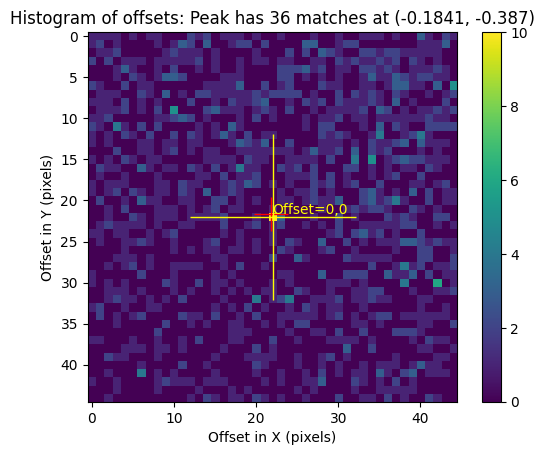

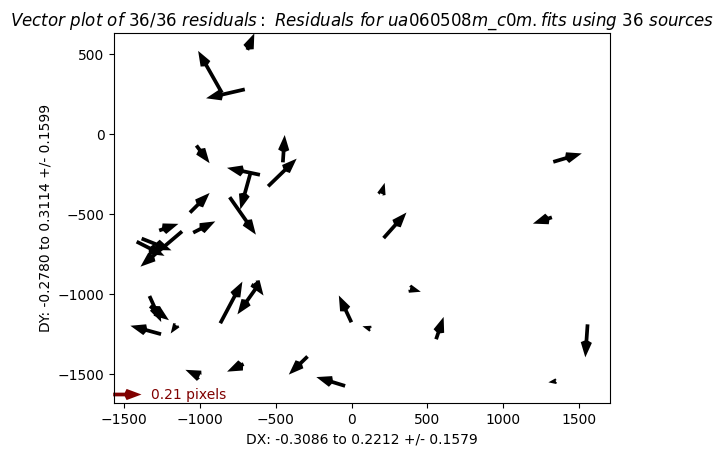

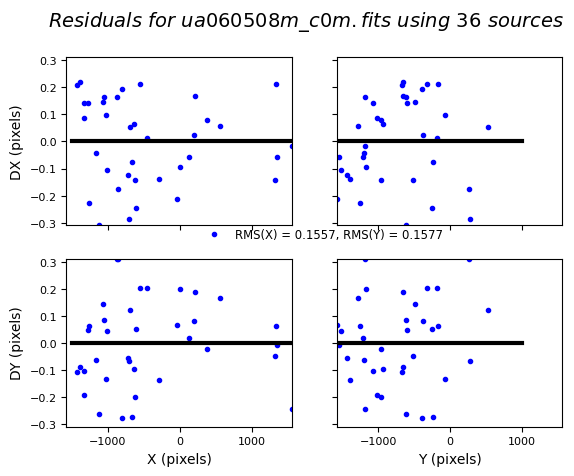

In [6]:
tweakreg.TweakReg('ua*c0m.fits', updatehdr=True, reusename=True, interactive=False,
                  conv_width=3.0, threshold=300.0, peakmin=100, peakmax=10000)

## 4. Equalize the chip sensitivities <a id="equalize"></a>

This step adjusts image data values so that all images and chips appear (to `AstroDrizzle`) to have a single inverse sensitivity (`PHOTFLAM`). This can be achieved using the `photeq` task in `Drizzlepac`. This task adjusts image data so that when these data are multiplied by the same single `PHOTFLAM` value, the correct flux is obtained.

In [7]:
photeq.photeq(files='ua*_c0m.fits', ref_phot_ext=3, readonly=False)

***** photeq started on 2024-01-30 20:47:39.209240


      Version 3.5.1 


PRIMARY PHOTOMETRIC KEYWORD: PHOTFLAM


SECONDARY PHOTOMETRIC KEYWORD(S): PHOTFNU


REFERENCE VALUE FROM FILE: 'ua060504m_c0m.fits[3]'


REFERENCE 'PHOTFLAM' VALUE IS: 2.449067e-18


Processing file 'ua060504m_c0m.fits'


   * EXT: ('SCI', 1)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.507987e-18)


     - Computed conversion factor for data: 1.0240581413248393


     - Data have been multiplied by 1.0240581413248393


   * EXT: ('SCI', 2)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.458077e-18)


     - Computed conversion factor for data: 1.0036789520254041


     - Data have been multiplied by 1.0036789520254041


   * EXT: ('SCI', 3) - This is the "reference" extension.


          Nothing to do. Skipping this extension...


   * EXT: ('SCI', 4)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.498411e-18)


     - Computed conversion factor for data: 1.0201480808814134


     - Data have been multiplied by 1.0201480808814134


Processing file 'ua06050am_c0m.fits'


   * EXT: ('SCI', 1)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.507987e-18)


     - Computed conversion factor for data: 1.0240581413248393


     - Data have been multiplied by 1.0240581413248393


   * EXT: ('SCI', 2)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.458077e-18)


     - Computed conversion factor for data: 1.0036789520254041


     - Data have been multiplied by 1.0036789520254041


   * EXT: ('SCI', 3)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.449067e-18)


     - Computed conversion factor for data: 1.0


     - Data have been multiplied by 1.0


   * EXT: ('SCI', 4)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.498411e-18)


     - Computed conversion factor for data: 1.0201480808814134


     - Data have been multiplied by 1.0201480808814134


Processing file 'ua06050cm_c0m.fits'


   * EXT: ('SCI', 1)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.507987e-18)


     - Computed conversion factor for data: 1.0240581413248393


     - Data have been multiplied by 1.0240581413248393


   * EXT: ('SCI', 2)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.458077e-18)


     - Computed conversion factor for data: 1.0036789520254041


     - Data have been multiplied by 1.0036789520254041


   * EXT: ('SCI', 3)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.449067e-18)


     - Computed conversion factor for data: 1.0


     - Data have been multiplied by 1.0


   * EXT: ('SCI', 4)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.498411e-18)


     - Computed conversion factor for data: 1.0201480808814134


     - Data have been multiplied by 1.0201480808814134


Processing file 'ua060502m_c0m.fits'


   * EXT: ('SCI', 1)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.507987e-18)


     - Computed conversion factor for data: 1.0240581413248393


     - Data have been multiplied by 1.0240581413248393


   * EXT: ('SCI', 2)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.458077e-18)


     - Computed conversion factor for data: 1.0036789520254041


     - Data have been multiplied by 1.0036789520254041


   * EXT: ('SCI', 3)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.449067e-18)


     - Computed conversion factor for data: 1.0


     - Data have been multiplied by 1.0


   * EXT: ('SCI', 4)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.498411e-18)


     - Computed conversion factor for data: 1.0201480808814134


     - Data have been multiplied by 1.0201480808814134


Processing file 'ua060506m_c0m.fits'


   * EXT: ('SCI', 1)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.507987e-18)


     - Computed conversion factor for data: 1.0240581413248393


     - Data have been multiplied by 1.0240581413248393


   * EXT: ('SCI', 2)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.458077e-18)


     - Computed conversion factor for data: 1.0036789520254041


     - Data have been multiplied by 1.0036789520254041


   * EXT: ('SCI', 3)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.449067e-18)


     - Computed conversion factor for data: 1.0


     - Data have been multiplied by 1.0


   * EXT: ('SCI', 4)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.498411e-18)


     - Computed conversion factor for data: 1.0201480808814134


     - Data have been multiplied by 1.0201480808814134


Processing file 'ua060508m_c0m.fits'


   * EXT: ('SCI', 1)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.507987e-18)


     - Computed conversion factor for data: 1.0240581413248393


     - Data have been multiplied by 1.0240581413248393


   * EXT: ('SCI', 2)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.458077e-18)


     - Computed conversion factor for data: 1.0036789520254041


     - Data have been multiplied by 1.0036789520254041


   * EXT: ('SCI', 3)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.449067e-18)


     - Computed conversion factor for data: 1.0


     - Data have been multiplied by 1.0


   * EXT: ('SCI', 4)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.498411e-18)


     - Computed conversion factor for data: 1.0201480808814134


     - Data have been multiplied by 1.0201480808814134


Done.


In the above command, we instruct `photeq` to "equalize" all chips of all input images using the `PHOTFLAM` for the `WF3` chip (`ref_phot_ext=3`), using the first image as a reference. This reference `PHOTFLAM` value is reported in the log file:

```
REFERENCE VALUE FROM FILE: 'ua060502m_c0m.fits['SCI',1]'
REFERENCE 'PHOTFLAM' VALUE IS: 2.507987e-18
```

Upon the completion, `photeq` will not only adjust image data but also update `PHOTFLAM` values for all chips to this specific reference value.

## 5. Drizzle-combine the images <a id="drizzle"></a>

All four chips are now drizzled together with an output pixel scale set to that of the WF chips:

In [8]:

astrodrizzle.AstroDrizzle('ua*c0m.fits',
                          preserve=False,
                          driz_sep_bits='8,1024',
                          driz_sep_wcs=True,
                          driz_sep_scale=0.0996,
                          combine_type='median',
                          driz_cr_snr='5.5 3.5',
                          driz_cr_scale='2.0 1.5',
                          final_fillval=None,
                          final_bits='8,1024',
                          final_wcs=True,
                          final_scale=0.0996,
                          skysub=False)

Setting up logfile :  astrodrizzle.log


AstroDrizzle log file: astrodrizzle.log


AstroDrizzle Version 3.5.1 started at: 20:47:39.469 (30/01/2024)


==== Processing Step  Initialization  started at  20:47:39.470 (30/01/2024)


WCS Keywords


Number of WCS axes: 2


CTYPE : 'RA---TAN'  'DEC--TAN'  


CRVAL : 323.31869738682866  -0.8646112662373874  


CRPIX : 777.9854781573196  767.6957940734234  


CD1_1 CD1_2  : 5.4139087290260045e-06  -2.7131790149531608e-05  


CD2_1 CD2_2  : -2.7131790149531608e-05  -5.4139087290260045e-06  


NAXIS : 1555  1535


********************************************************************************


*


*  Estimated memory usage:  up to 128 Mb.


*  Output image size:       1555 X 1535 pixels. 


*  Output image file:       ~ 27 Mb. 


*  Cores available:         4


*


********************************************************************************


==== Processing Step Initialization finished at 20:47:41.103 (30/01/2024)


==== Processing Step  Static Mask  started at  20:47:41.105 (30/01/2024)


==== Processing Step Static Mask finished at 20:47:41.378 (30/01/2024)


==== Processing Step  Subtract Sky  started at  20:47:41.379 (30/01/2024)


==== Processing Step Subtract Sky finished at 20:47:41.673 (30/01/2024)


==== Processing Step  Separate Drizzle  started at  20:47:41.674 (30/01/2024)


WCS Keywords


Number of WCS axes: 2


CTYPE : 'RA---TAN'  'DEC--TAN'  


CRVAL : 323.31869738682866  -0.8646112662373874  


CRPIX : 777.9854781573196  767.6957940734234  


CD1_1 CD1_2  : 5.4139087290260045e-06  -2.7131790149531608e-05  


CD2_1 CD2_2  : -2.7131790149531608e-05  -5.4139087290260045e-06  


NAXIS : 1555  1535


-Generating simple FITS output: ua060502m_c0m_single_sci.fits


-Generating simple FITS output: ua060504m_c0m_single_sci.fits


-Generating simple FITS output: ua060508m_c0m_single_sci.fits


Writing out image to disk: ua060502m_c0m_single_sci.fits


Writing out image to disk: ua060504m_c0m_single_sci.fits


-Generating simple FITS output: ua060506m_c0m_single_sci.fits


Writing out image to disk: ua060508m_c0m_single_sci.fits


Deleted all instances of WCS with key A in extensions [0]


Deleted all instances of WCS with key A in extensions [0]


Deleted all instances of WCS with key B in extensions [0]


Deleted all instances of WCS with key A in extensions [0]


Deleted all instances of WCS with key B in extensions [0]


Writing out image to disk: ua060506m_c0m_single_sci.fits


Writing out image to disk: ua060502m_c0m_single_wht.fits


Deleted all instances of WCS with key B in extensions [0]


Writing out image to disk: ua060504m_c0m_single_wht.fits


Writing out image to disk: ua060508m_c0m_single_wht.fits


Deleted all instances of WCS with key A in extensions [0]


Deleted all instances of WCS with key B in extensions [0]


Writing out image to disk: ua060506m_c0m_single_wht.fits


-Generating simple FITS output: ua06050am_c0m_single_sci.fits


-Generating simple FITS output: ua06050cm_c0m_single_sci.fits


Writing out image to disk: ua06050am_c0m_single_sci.fits


Writing out image to disk: ua06050cm_c0m_single_sci.fits


Deleted all instances of WCS with key A in extensions [0]


Deleted all instances of WCS with key A in extensions [0]


Deleted all instances of WCS with key B in extensions [0]


Deleted all instances of WCS with key B in extensions [0]


Writing out image to disk: ua06050am_c0m_single_wht.fits


Writing out image to disk: ua06050cm_c0m_single_wht.fits


==== Processing Step Separate Drizzle finished at 20:47:44.746 (30/01/2024)


==== Processing Step  Create Median  started at  20:47:44.748 (30/01/2024)


reference sky value for image 'ua060502m_c0m.fits' is 0.0


reference sky value for image 'ua060504m_c0m.fits' is 0.0


reference sky value for image 'ua060506m_c0m.fits' is 0.0


reference sky value for image 'ua060508m_c0m.fits' is 0.0


reference sky value for image 'ua06050am_c0m.fits' is 0.0


reference sky value for image 'ua06050cm_c0m.fits' is 0.0


Saving output median image to: 'final_drw_med.fits'


==== Processing Step Create Median finished at 20:47:45.275 (30/01/2024)


==== Processing Step  Blot  started at  20:47:45.276 (30/01/2024)


    Blot: creating blotted image:  ua060502m_c0m.fits[sci,1]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060502m_c0m_sci1_blt.fits


Writing out image to disk: ua060502m_c0m_sci1_blt.fits


    Blot: creating blotted image:  ua060502m_c0m.fits[sci,2]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060502m_c0m_sci2_blt.fits


Writing out image to disk: ua060502m_c0m_sci2_blt.fits


    Blot: creating blotted image:  ua060502m_c0m.fits[sci,3]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060502m_c0m_sci3_blt.fits


Writing out image to disk: ua060502m_c0m_sci3_blt.fits


    Blot: creating blotted image:  ua060502m_c0m.fits[sci,4]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060502m_c0m_sci4_blt.fits


Writing out image to disk: ua060502m_c0m_sci4_blt.fits


    Blot: creating blotted image:  ua060504m_c0m.fits[sci,1]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060504m_c0m_sci1_blt.fits


Writing out image to disk: ua060504m_c0m_sci1_blt.fits


    Blot: creating blotted image:  ua060504m_c0m.fits[sci,2]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060504m_c0m_sci2_blt.fits


Writing out image to disk: ua060504m_c0m_sci2_blt.fits


    Blot: creating blotted image:  ua060504m_c0m.fits[sci,3]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060504m_c0m_sci3_blt.fits


Writing out image to disk: ua060504m_c0m_sci3_blt.fits


    Blot: creating blotted image:  ua060504m_c0m.fits[sci,4]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060504m_c0m_sci4_blt.fits


Writing out image to disk: ua060504m_c0m_sci4_blt.fits


    Blot: creating blotted image:  ua060506m_c0m.fits[sci,1]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060506m_c0m_sci1_blt.fits


Writing out image to disk: ua060506m_c0m_sci1_blt.fits


    Blot: creating blotted image:  ua060506m_c0m.fits[sci,2]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060506m_c0m_sci2_blt.fits


Writing out image to disk: ua060506m_c0m_sci2_blt.fits


    Blot: creating blotted image:  ua060506m_c0m.fits[sci,3]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060506m_c0m_sci3_blt.fits


Writing out image to disk: ua060506m_c0m_sci3_blt.fits


    Blot: creating blotted image:  ua060506m_c0m.fits[sci,4]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060506m_c0m_sci4_blt.fits


Writing out image to disk: ua060506m_c0m_sci4_blt.fits


    Blot: creating blotted image:  ua060508m_c0m.fits[sci,1]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060508m_c0m_sci1_blt.fits


Writing out image to disk: ua060508m_c0m_sci1_blt.fits


    Blot: creating blotted image:  ua060508m_c0m.fits[sci,2]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060508m_c0m_sci2_blt.fits


Writing out image to disk: ua060508m_c0m_sci2_blt.fits


    Blot: creating blotted image:  ua060508m_c0m.fits[sci,3]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060508m_c0m_sci3_blt.fits


Writing out image to disk: ua060508m_c0m_sci3_blt.fits


    Blot: creating blotted image:  ua060508m_c0m.fits[sci,4]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060508m_c0m_sci4_blt.fits


Writing out image to disk: ua060508m_c0m_sci4_blt.fits


    Blot: creating blotted image:  ua06050am_c0m.fits[sci,1]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua06050am_c0m_sci1_blt.fits


Writing out image to disk: ua06050am_c0m_sci1_blt.fits


    Blot: creating blotted image:  ua06050am_c0m.fits[sci,2]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua06050am_c0m_sci2_blt.fits


Writing out image to disk: ua06050am_c0m_sci2_blt.fits


    Blot: creating blotted image:  ua06050am_c0m.fits[sci,3]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua06050am_c0m_sci3_blt.fits


Writing out image to disk: ua06050am_c0m_sci3_blt.fits


    Blot: creating blotted image:  ua06050am_c0m.fits[sci,4]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua06050am_c0m_sci4_blt.fits


Writing out image to disk: ua06050am_c0m_sci4_blt.fits


    Blot: creating blotted image:  ua06050cm_c0m.fits[sci,1]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua06050cm_c0m_sci1_blt.fits


Writing out image to disk: ua06050cm_c0m_sci1_blt.fits


    Blot: creating blotted image:  ua06050cm_c0m.fits[sci,2]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua06050cm_c0m_sci2_blt.fits


Writing out image to disk: ua06050cm_c0m_sci2_blt.fits


    Blot: creating blotted image:  ua06050cm_c0m.fits[sci,3]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua06050cm_c0m_sci3_blt.fits


Writing out image to disk: ua06050cm_c0m_sci3_blt.fits


    Blot: creating blotted image:  ua06050cm_c0m.fits[sci,4]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua06050cm_c0m_sci4_blt.fits


Writing out image to disk: ua06050cm_c0m_sci4_blt.fits


==== Processing Step Blot finished at 20:47:49.309 (30/01/2024)


==== Processing Step  Driz_CR  started at  20:47:49.310 (30/01/2024)


Removed old cosmic ray mask file: 'ua060502m_c0m_sci1_crmask.fits'


Creating output: ua060502m_c0m_sci1_crmask.fits


Removed old cosmic ray mask file: 'ua060504m_c0m_sci1_crmask.fits'


Creating output: ua060504m_c0m_sci1_crmask.fits


Removed old cosmic ray mask file: 'ua060506m_c0m_sci1_crmask.fits'


Creating output: ua060506m_c0m_sci1_crmask.fits


Removed old cosmic ray mask file: 'ua060508m_c0m_sci1_crmask.fits'


Creating output: ua060508m_c0m_sci1_crmask.fits


Removed old cosmic ray mask file: 'ua060502m_c0m_sci2_crmask.fits'


Creating output: ua060502m_c0m_sci2_crmask.fits


Removed old cosmic ray mask file: 'ua060504m_c0m_sci2_crmask.fits'


Creating output: ua060504m_c0m_sci2_crmask.fits


Removed old cosmic ray mask file: 'ua060506m_c0m_sci2_crmask.fits'


Creating output: ua060506m_c0m_sci2_crmask.fits


Removed old cosmic ray mask file: 'ua060508m_c0m_sci2_crmask.fits'


Creating output: ua060508m_c0m_sci2_crmask.fits


Removed old cosmic ray mask file: 'ua060502m_c0m_sci3_crmask.fits'


Creating output: ua060502m_c0m_sci3_crmask.fits


Removed old cosmic ray mask file: 'ua060504m_c0m_sci3_crmask.fits'


Creating output: ua060504m_c0m_sci3_crmask.fits


Removed old cosmic ray mask file: 'ua060506m_c0m_sci3_crmask.fits'


Creating output: ua060506m_c0m_sci3_crmask.fits


Removed old cosmic ray mask file: 'ua060508m_c0m_sci3_crmask.fits'


Creating output: ua060508m_c0m_sci3_crmask.fits


Removed old cosmic ray mask file: 'ua060502m_c0m_sci4_crmask.fits'


Creating output: ua060502m_c0m_sci4_crmask.fits


Removed old cosmic ray mask file: 'ua060504m_c0m_sci4_crmask.fits'


Creating output: ua060504m_c0m_sci4_crmask.fits


Removed old cosmic ray mask file: 'ua060506m_c0m_sci4_crmask.fits'


Creating output: ua060506m_c0m_sci4_crmask.fits


Removed old cosmic ray mask file: 'ua060508m_c0m_sci4_crmask.fits'


Creating output: ua060508m_c0m_sci4_crmask.fits


Removed old cosmic ray mask file: 'ua06050am_c0m_sci1_crmask.fits'


Creating output: ua06050am_c0m_sci1_crmask.fits


Removed old cosmic ray mask file: 'ua06050cm_c0m_sci1_crmask.fits'


Creating output: ua06050cm_c0m_sci1_crmask.fits


Removed old cosmic ray mask file: 'ua06050am_c0m_sci2_crmask.fits'


Creating output: ua06050am_c0m_sci2_crmask.fits


Removed old cosmic ray mask file: 'ua06050cm_c0m_sci2_crmask.fits'


Creating output: ua06050cm_c0m_sci2_crmask.fits


Removed old cosmic ray mask file: 'ua06050am_c0m_sci3_crmask.fits'


Creating output: ua06050am_c0m_sci3_crmask.fits


Removed old cosmic ray mask file: 'ua06050cm_c0m_sci3_crmask.fits'


Creating output: ua06050cm_c0m_sci3_crmask.fits


Removed old cosmic ray mask file: 'ua06050am_c0m_sci4_crmask.fits'


Removed old cosmic ray mask file: 'ua06050cm_c0m_sci4_crmask.fits'


Creating output: ua06050am_c0m_sci4_crmask.fits


Creating output: ua06050cm_c0m_sci4_crmask.fits


==== Processing Step Driz_CR finished at 20:47:51.565 (30/01/2024)


==== Processing Step  Final Drizzle  started at  20:47:51.581 (30/01/2024)


WCS Keywords


Number of WCS axes: 2


CTYPE : 'RA---TAN'  'DEC--TAN'  


CRVAL : 323.31869738682866  -0.8646112662373874  


CRPIX : 777.9854781573196  767.6957940734234  


CD1_1 CD1_2  : 5.4139087290260045e-06  -2.7131790149531608e-05  


CD2_1 CD2_2  : -2.7131790149531608e-05  -5.4139087290260045e-06  


NAXIS : 1555  1535


-Generating simple FITS output: final_drw_sci.fits


Writing out image to disk: final_drw_sci.fits


Deleted all instances of WCS with key A in extensions [0]


Deleted all instances of WCS with key B in extensions [0]


Writing out image to disk: final_drw_wht.fits


Deleted all instances of WCS with key A in extensions [0]


Deleted all instances of WCS with key B in extensions [0]


Writing out image to disk: final_drw_ctx.fits


==== Processing Step Final Drizzle finished at 20:47:58.700 (30/01/2024)


AstroDrizzle Version 3.5.1 is finished processing at 20:47:58.701 (30/01/2024).


   --------------------          --------------------


                   Step          Elapsed time


   --------------------          --------------------


         Initialization          1.6329 sec.


            Static Mask          0.2734 sec.


           Subtract Sky          0.2936 sec.


       Separate Drizzle          3.0727 sec.


          Create Median          0.5272 sec.


                   Blot          4.0330 sec.


                Driz_CR          2.2546 sec.


          Final Drizzle          7.1189 sec.


   ====================          ====================


                  Total          19.2064 sec.


Trailer file written to:  astrodrizzle.log


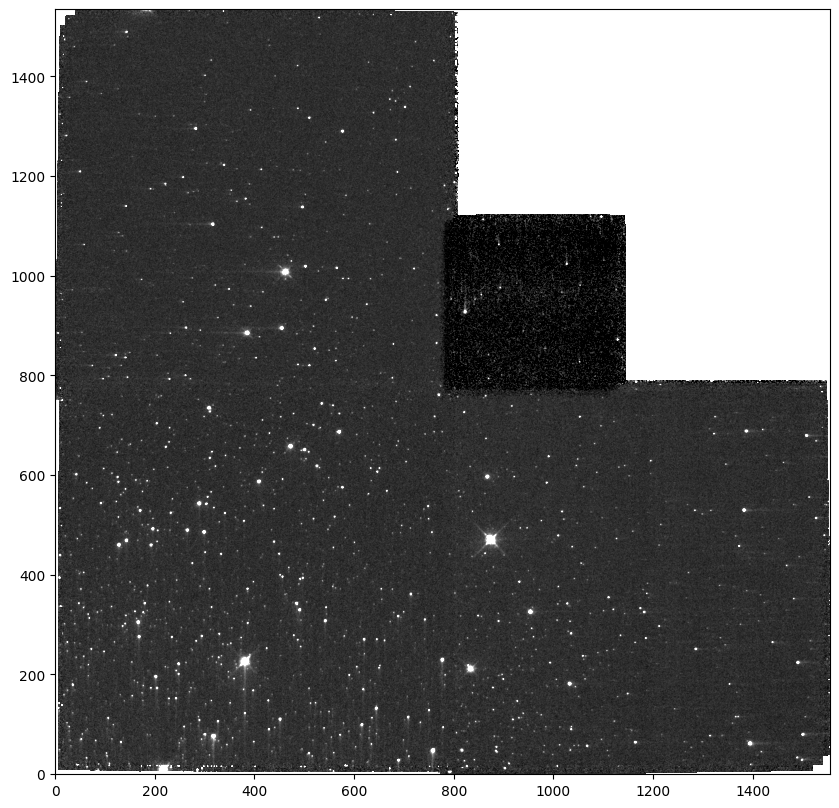

In [9]:
drw_data = fits.getdata('final_drw_sci.fits')
plt.figure(figsize=(10, 10))
plt.imshow(drw_data, cmap='gray', vmin=-0.1, vmax=0.5, origin='lower')
plt.show()

## 6. Illustration of the Effects of Sensitivity Variation on Drizzling <a id="example"></a>

The effect of drizzling images with different detector sensitivies, while tangible, is sometimes difficult to _visualize_ in noisy data, especially when drizzling multiple dithered images that can blur the borders between chips.

In this section we produce a simple simulation of observing a constant intensity "blank sky". We then make a copy of this image and apply sensitivity equalization to it. Finally we drizzle both images and compare them side-by-side.

### Simulate an Image of Constant "Blank Sky" Background <a id="constant"></a>

In this simple simulation we assume only Poisson noise.

In [10]:
with fits.open(backup_image, mode='update') as h:
    # get chip inverse-sensitivity:
    phot1 = h[1].header['PHOTFLAM']
    phot2 = h[2].header['PHOTFLAM']
    phot3 = h[3].header['PHOTFLAM']
    phot4 = h[4].header['PHOTFLAM']
    
    # get chip WCS:
    w1 = HSTWCS(h, ext=1)
    w2 = HSTWCS(h, ext=2)
    w3 = HSTWCS(h, ext=3)
    w4 = HSTWCS(h, ext=4)
    ref_pscale = w4.idcscale
    
    # get chip gain:
    cmdgain = h[0].header['ATODGAIN']
    gain1 = WFPC2_GAINS[1][cmdgain][0]
    gain2 = WFPC2_GAINS[2][cmdgain][0]
    gain3 = WFPC2_GAINS[3][cmdgain][0]
    gain4 = WFPC2_GAINS[4][cmdgain][0]
    
    # final drizzle scale:
    scale = 0.0996
    
    # simulated sky level ("true" sky is constant):
    sky = 10 * phot3

    # simulate observed counts assuming only Poisson noise:
    conv1a = gain1 * (w1.idcscale / ref_pscale)**2 / phot1
    conv1b = (gain4 / gain1**2) * (ref_pscale / scale)**2
    conv2a = gain2 * (w2.idcscale / ref_pscale)**2 / phot2
    conv2b = (gain4 / gain2**2) * (ref_pscale / scale)**2
    conv3a = gain3 * (w3.idcscale / ref_pscale)**2 / phot3
    conv3b = (gain4 / gain3**2) * (ref_pscale / scale)**2
    conv4a = gain4 * (w4.idcscale / ref_pscale)**2 / phot4
    conv4b = (1.0 / gain4) * (ref_pscale / scale)**2

    h[1].data[:, :] = np.random.poisson(conv1a * sky, h[1].data.shape) * conv1b
    h[2].data[:, :] = np.random.poisson(conv2a * sky, h[2].data.shape) * conv2b
    h[3].data[:, :] = np.random.poisson(conv3a * sky, h[3].data.shape) * conv3b
    h[4].data[:, :] = np.random.poisson(conv4a * sky, h[4].data.shape) * conv4b

# make a copy of this file:
photeq_image = 'simulation_eq.fits'
if os.path.isfile(photeq_image):
    os.remove(photeq_image)
shutil.copy2(backup_image, photeq_image)

# apply equalization to the image copy:
photeq.photeq(files=photeq_image, ref_phot_ext=3, readonly=False)

***** photeq started on 2024-01-30 20:47:59.401721


      Version 3.5.1 


PRIMARY PHOTOMETRIC KEYWORD: PHOTFLAM


SECONDARY PHOTOMETRIC KEYWORD(S): PHOTFNU


REFERENCE VALUE FROM FILE: 'simulation_eq.fits[3]'


REFERENCE 'PHOTFLAM' VALUE IS: 2.449067e-18


Processing file 'simulation_eq.fits'


   * EXT: ('SCI', 1)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.507987e-18)


     - Computed conversion factor for data: 1.0240581413248393


     - Data have been multiplied by 1.0240581413248393


   * EXT: ('SCI', 2)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.458077e-18)


     - Computed conversion factor for data: 1.0036789520254041


     - Data have been multiplied by 1.0036789520254041


   * EXT: ('SCI', 3) - This is the "reference" extension.


          Nothing to do. Skipping this extension...


   * EXT: ('SCI', 4)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.498411e-18)


     - Computed conversion factor for data: 1.0201480808814134


     - Data have been multiplied by 1.0201480808814134


Done.


We need to make a simulated DQ array. We used the first science image in the downloaded dataset for the simulation, so we will use its DQ image. 

In [11]:
# make an DQ array for every 
hdu = fits.open('ua06050cm_c1m.fits')
shape = np.shape(hdu[1].data)
zero_DQ = np.zeros(shape)

fits_file = fits.HDUList()
# copy all of its extensions over, including the header
hdu0 = fits.PrimaryHDU(header=hdu[0].header)
hdu1 = fits.ImageHDU(hdu[1].data, header=hdu[1].header)
hdu2 = fits.ImageHDU(hdu[2].data, header=hdu[2].header)
hdu3 = fits.ImageHDU(hdu[3].data, header=hdu[3].header)
hdu4 = fits.ImageHDU(hdu[4].data, header=hdu[4].header)

fits_file.append(hdu0)
fits_file.append(hdu1)
fits_file.append(hdu2)
fits_file.append(hdu3)
fits_file.append(hdu4)

fits_file.writeto('simula_c1n.fits', overwrite=True)
fits_file.writeto('simulatio_c1q.fits', overwrite=True)

### Drizzle the Original Simulated Image and the Equalized Image <a id="drizzling"></a>

In [12]:
astrodrizzle.AstroDrizzle(
    backup_image,
    output='nonequalized.fits',
    stepsize=1,
    preserve=False,
    restore=False,
    in_memory=True,
    context=False,
    build=False,
    static=False,
    skysub=False,
    median=False,
    blot=False,
    driz_cr=False,
    final_fillval=None,
    final_bits='',
    final_wcs=True,
    final_scale=scale)

astrodrizzle.AstroDrizzle(
    photeq_image,
    output='equalized.fits',
    stepsize=1,
    preserve=False,
    restore=False,
    in_memory=True,
    context=False,
    build=False,
    static=False,
    skysub=False,
    median=False,
    blot=False,
    driz_cr=False,
    final_fillval=None,
    final_bits='',
    final_wcs=True,
    final_scale=scale)

Setting up logfile :  astrodrizzle.log


AstroDrizzle log file: astrodrizzle.log


AstroDrizzle Version 3.5.1 started at: 20:47:59.51 (30/01/2024)


==== Processing Step  Initialization  started at  20:47:59.516 (30/01/2024)


WCS Keywords


Number of WCS axes: 2


CTYPE : 'RA---TAN'  'DEC--TAN'  


CRVAL : 323.3185730218877  -0.8645263865112922  


CRPIX : 761.5219836230858  751.4609591854984  


CD1_1 CD1_2  : 5.413908749689736e-06  -2.7131790145408346e-05  


CD2_1 CD2_2  : -2.7131790145408346e-05  -5.413908749689736e-06  


NAXIS : 1522  1502


********************************************************************************


*


*  Estimated memory usage:  up to 124 Mb.


*  Output image size:       1522 X 1502 pixels. 


*  Output image file:       ~ 26 Mb. 


*  Cores available:         4


*


********************************************************************************


==== Processing Step Initialization finished at 20:47:59.787 (30/01/2024)


==== Processing Step  Static Mask  started at  20:47:59.788 (30/01/2024)


==== Processing Step Static Mask finished at 20:47:59.789 (30/01/2024)


==== Processing Step  Subtract Sky  started at  20:47:59.790 (30/01/2024)


==== Processing Step Subtract Sky finished at 20:47:59.824 (30/01/2024)


==== Processing Step  Separate Drizzle  started at  20:47:59.82 (30/01/2024)


WCS Keywords


Number of WCS axes: 2


CTYPE : 'RA---TAN'  'DEC--TAN'  


CRVAL : 323.3185730218877  -0.8645263865112922  


CRPIX : 1664.0  1642.0  


CD1_1 CD1_2  : 2.4758849197044006e-06  -1.2407891076747593e-05  


CD2_1 CD2_2  : -1.2407891076747593e-05  -2.4758849197044006e-06  


NAXIS : 3328  3284


-Generating simple FITS output: simulation_single_sci.fits


Writing out image to disk: simulation_single_sci.fits


Deleted all instances of WCS with key A in extensions [0]


Deleted all instances of WCS with key B in extensions [0]


==== Processing Step Separate Drizzle finished at 20:48:01.343 (30/01/2024)


==== Processing Step  Create Median  started at  20:48:01.344 (30/01/2024)


==== Processing Step  Blot  started at  20:48:01.345 (30/01/2024)


==== Processing Step Blot finished at 20:48:01.346 (30/01/2024)


==== Processing Step  Driz_CR  started at  20:48:01.347 (30/01/2024)


==== Processing Step  Final Drizzle  started at  20:48:01.348 (30/01/2024)


WCS Keywords


Number of WCS axes: 2


CTYPE : 'RA---TAN'  'DEC--TAN'  


CRVAL : 323.3185730218877  -0.8645263865112922  


CRPIX : 761.5219836230858  751.4609591854984  


CD1_1 CD1_2  : 5.413908749689736e-06  -2.7131790145408346e-05  


CD2_1 CD2_2  : -2.7131790145408346e-05  -5.413908749689736e-06  


NAXIS : 1522  1502


-Generating simple FITS output: nonequalized_sci.fits


Writing out image to disk: nonequalized_sci.fits


Deleted all instances of WCS with key A in extensions [0]


Deleted all instances of WCS with key B in extensions [0]


Writing out image to disk: nonequalized_wht.fits


==== Processing Step Final Drizzle finished at 20:48:03.375 (30/01/2024)


AstroDrizzle Version 3.5.1 is finished processing at 20:48:03.377 (30/01/2024).


   --------------------          --------------------


                   Step          Elapsed time


   --------------------          --------------------


         Initialization          0.2704 sec.


            Static Mask          0.0012 sec.


           Subtract Sky          0.0344 sec.


       Separate Drizzle          1.5172 sec.


          Create Median          0.0000 sec.


                   Blot          0.0013 sec.


                Driz_CR          0.0000 sec.


          Final Drizzle          2.0268 sec.


   ====================          ====================


                  Total          3.8513 sec.


Trailer file written to:  astrodrizzle.log


Setting up logfile :  astrodrizzle.log


AstroDrizzle log file: astrodrizzle.log


AstroDrizzle Version 3.5.1 started at: 20:48:03.409 (30/01/2024)


==== Processing Step  Initialization  started at  20:48:03.411 (30/01/2024)


WCS Keywords


Number of WCS axes: 2


CTYPE : 'RA---TAN'  'DEC--TAN'  


CRVAL : 323.3185730218877  -0.8645263865112922  


CRPIX : 761.5219836230858  751.4609591854984  


CD1_1 CD1_2  : 5.413908749689736e-06  -2.7131790145408346e-05  


CD2_1 CD2_2  : -2.7131790145408346e-05  -5.413908749689736e-06  


NAXIS : 1522  1502


********************************************************************************


*


*  Estimated memory usage:  up to 124 Mb.


*  Output image size:       1522 X 1502 pixels. 


*  Output image file:       ~ 26 Mb. 


*  Cores available:         4


*


********************************************************************************


==== Processing Step Initialization finished at 20:48:03.683 (30/01/2024)


==== Processing Step  Static Mask  started at  20:48:03.685 (30/01/2024)


==== Processing Step Static Mask finished at 20:48:03.68 (30/01/2024)


==== Processing Step  Subtract Sky  started at  20:48:03.687 (30/01/2024)


==== Processing Step Subtract Sky finished at 20:48:03.722 (30/01/2024)


==== Processing Step  Separate Drizzle  started at  20:48:03.723 (30/01/2024)


WCS Keywords


Number of WCS axes: 2


CTYPE : 'RA---TAN'  'DEC--TAN'  


CRVAL : 323.3185730218877  -0.8645263865112922  


CRPIX : 1664.0  1642.0  


CD1_1 CD1_2  : 2.4758849197044006e-06  -1.2407891076747593e-05  


CD2_1 CD2_2  : -1.2407891076747593e-05  -2.4758849197044006e-06  


NAXIS : 3328  3284


-Generating simple FITS output: simulation_eq_single_sci.fits


Writing out image to disk: simulation_eq_single_sci.fits


Deleted all instances of WCS with key A in extensions [0]


Deleted all instances of WCS with key B in extensions [0]


==== Processing Step Separate Drizzle finished at 20:48:05.21 (30/01/2024)


==== Processing Step  Create Median  started at  20:48:05.220 (30/01/2024)


==== Processing Step  Blot  started at  20:48:05.221 (30/01/2024)


==== Processing Step Blot finished at 20:48:05.223 (30/01/2024)


==== Processing Step  Driz_CR  started at  20:48:05.223 (30/01/2024)


==== Processing Step  Final Drizzle  started at  20:48:05.225 (30/01/2024)


WCS Keywords


Number of WCS axes: 2


CTYPE : 'RA---TAN'  'DEC--TAN'  


CRVAL : 323.3185730218877  -0.8645263865112922  


CRPIX : 761.5219836230858  751.4609591854984  


CD1_1 CD1_2  : 5.413908749689736e-06  -2.7131790145408346e-05  


CD2_1 CD2_2  : -2.7131790145408346e-05  -5.413908749689736e-06  


NAXIS : 1522  1502


-Generating simple FITS output: equalized_sci.fits


Writing out image to disk: equalized_sci.fits


Deleted all instances of WCS with key A in extensions [0]


Deleted all instances of WCS with key B in extensions [0]


Writing out image to disk: equalized_wht.fits


==== Processing Step Final Drizzle finished at 20:48:07.222 (30/01/2024)


AstroDrizzle Version 3.5.1 is finished processing at 20:48:07.223 (30/01/2024).


   --------------------          --------------------


                   Step          Elapsed time


   --------------------          --------------------


         Initialization          0.2728 sec.


            Static Mask          0.0013 sec.


           Subtract Sky          0.0350 sec.


       Separate Drizzle          1.4962 sec.


          Create Median          0.0000 sec.


                   Blot          0.0013 sec.


                Driz_CR          0.0000 sec.


          Final Drizzle          1.9971 sec.


   ====================          ====================


                  Total          3.8038 sec.


Trailer file written to:  astrodrizzle.log


### Display The Results of the Simulation Side-by-Side <a id="display"></a>

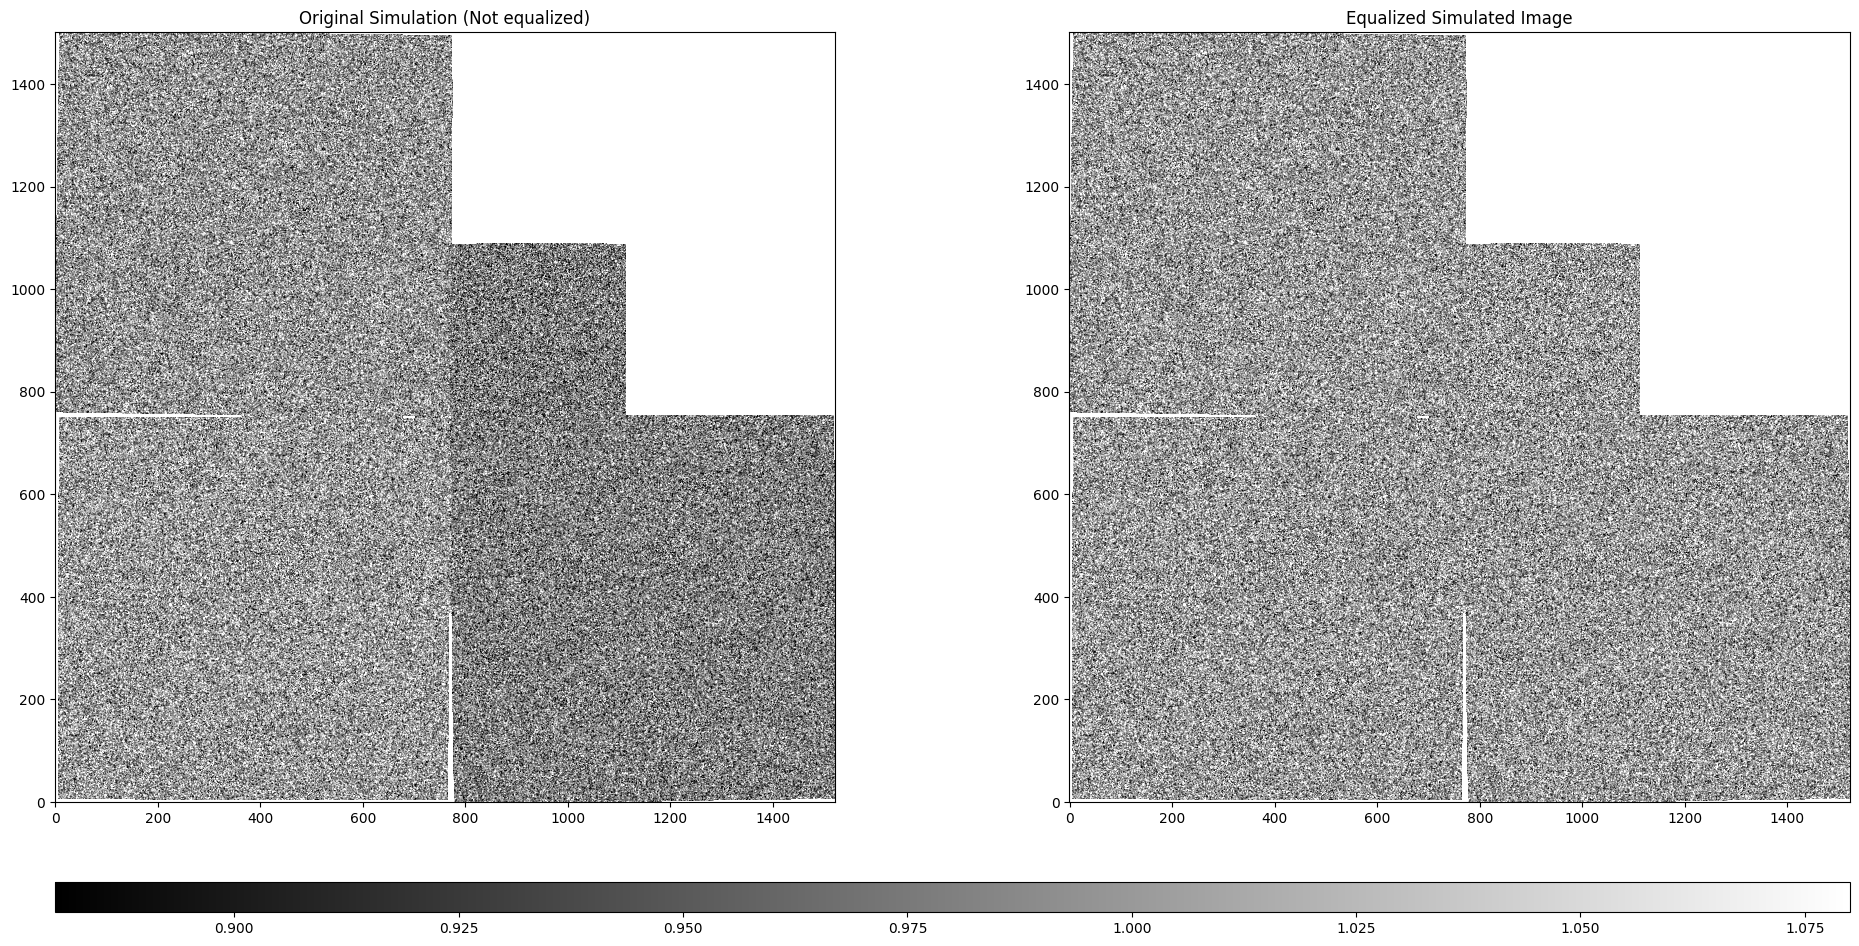

In [13]:
%matplotlib inline
drz_noneq = fits.getdata('nonequalized_sci.fits')
drz_eq = fits.getdata('equalized_sci.fits')

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(24, 10))
im1 = ax1.imshow(drz_noneq, cmap='gray', vmin=0.88, vmax=1.08, origin='lower')
ax1.set_title('Original Simulation (Not equalized)')
im2 = ax2.imshow(drz_eq, cmap='gray', vmin=0.88, vmax=1.08, origin='lower')
ax2.set_title('Equalized Simulated Image')

x1 = ax1.get_position().get_points().flatten()[0]
x2 = ax2.get_position().get_points().flatten()[2] - x1
ax_cbar = fig.add_axes([x1, 0, x2, 0.03])
plt.colorbar(im1, cax=ax_cbar, orientation='horizontal')

The equalized image now have a ~constant background noise between all of the detectors with different sensitivities compared to the orignial simulation that has not been equalized.


    Author: M. Cara, STScI Data Analysis Tools Branch
            K. Huynh, WFC3 Instrument Branch
    Created: December 14, 2018
    Updated: November 16, 2023